In [1]:
import pandas as pd
import numpy as np
import joblib
import sys
sys.path.append('../')

from premier_league import constants
if constants.RUN_DATA_EXPECTATIONS:
    from expectations_helpers import (
        AutoGreatExpectations,
        view_full_suite,
        view_suite_summary,
        save_expectations,
        load_expectations,
        validate_data
    )
from premier_league import (
    preprocessing,
    preprocessing_helpers,
    training,
    evaluation,
    prediction,
    data_extraction,
    visualisations,
    s3_helpers,
)

In [2]:
import importlib
importlib.reload(constants)


<module 'premier_league.constants' from '/Users/david@inawisdom.com/Documents/Training/premier_league/notebooks/../premier_league/constants.py'>

In [3]:
# Timestamp for current run
current_timestamp = s3_helpers.get_current_date_time()
current_timestamp

'2023-11-12 11:35:38'

In [4]:
df = s3_helpers.grab_data_s3(constants.TRAINING_DATA_LOCATION)
df = df[constants.COLUMNS_REQ]

In [5]:
df.head()

,season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1995-96,19/08/95,Aston Villa,Man United,3.0,1.0,H
1,1995-96,19/08/95,Blackburn,QPR,1.0,0.0,H
2,1995-96,19/08/95,Chelsea,Everton,0.0,0.0,D
3,1995-96,19/08/95,Liverpool,Sheffield Weds,1.0,0.0,H
4,1995-96,19/08/95,Man City,Tottenham,1.0,1.0,D


### Set up data validation

In [6]:
if constants.RUN_DATA_EXPECTATIONS:
    ge_class = AutoGreatExpectations(df)

In [7]:
if constants.RUN_DATA_EXPECTATIONS:
    ge_data = ge_class.generate_expectations(verbose=False)

In [8]:
if constants.RUN_DATA_EXPECTATIONS:
    view_suite_summary(ge_data)

In [9]:
if constants.RUN_DATA_EXPECTATIONS:
    save_expectations(ge_data, constants.exp_loc)

### Validate data

In [10]:
if constants.RUN_DATA_EXPECTATIONS:
    data_expectations = load_expectations(constants.exp_loc)

In [11]:
if constants.INITIAL_DATA_LOAD:
    full_data = data_extraction.load_all_data(
        constants.TRAINING_DATA_LOCATION,
        constants.COLUMNS_REQ
    )
else:
    full_data = s3_helpers.grab_data_s3(
        constants.TRAINING_DATA_LOCATION)


In [12]:
full_data = data_extraction.add_new_data(
    full_data, 
    constants.COLUMNS_REQ,
    constants.TRAINING_DATA_LOCATION
)

Data saved at app_data/training_data_full.csv


In [13]:
if constants.RUN_DATA_EXPECTATIONS:
    validation_results = validate_data(full_data, data_expectations)

### Preprocessing

In [14]:
df = s3_helpers.grab_data_s3(constants.TRAINING_DATA_LOCATION)
df = df[constants.COLUMNS_REQ]
df.head()

,season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1995-96,19/08/95,Aston Villa,Man United,3.0,1.0,H
1,1995-96,19/08/95,Blackburn,QPR,1.0,0.0,H
2,1995-96,19/08/95,Chelsea,Everton,0.0,0.0,D
3,1995-96,19/08/95,Liverpool,Sheffield Weds,1.0,0.0,H
4,1995-96,19/08/95,Man City,Tottenham,1.0,1.0,D


In [15]:
transformers = preprocessing.fit_transformers(
    df
)

In [16]:
s3_helpers.save_transformer_s3_pickle(
    transformers, 
    constants.TRANSFORMER_PATH
)

Transformer object is saved to S3 bucket premier-league-app at app_data/transformers/transformer_v2.pkl


In [17]:
transformed_data = preprocessing.transform_data(
    df, transformers
)

In [18]:
#transformed_data = transformed_data.drop(['HomeTeam', 'AwayTeam', 'season'], axis=1)

In [19]:
training_data, testing_data = preprocessing.split_data(transformed_data)

In [20]:
training_data.shape

(8600, 33)

In [21]:
testing_data.shape

(2150, 33)

In [22]:
training_data.head(2)

,season,HomeTeam,AwayTeam,FTR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5,MW,HTFormPts,ATFormPts,HTGD,ATGD,DiffPts,DiffFormPts,HomeLeaguePosition,AwayLeaguePosition,LeaguePositionDiff,MatchDayDay,MatchDayMonth,MatchDayDate
0,2016-17,Stoke,Middlesbrough,0,30.0,19.0,40.0,28.0,1.185185,0.814815,L,L,W,D,L,L,D,D,D,L,27.0,5,2,-0.37037,-0.333333,0.37037,0.111111,9,15,-6,Saturday,March,4
1,2022-23,Fulham,Tottenham,2,32.0,37.0,28.0,27.0,1.550000,1.650000,W,L,W,W,W,L,W,D,L,W,20.0,12,7,0.20000,0.500000,-0.10000,0.250000,6,5,1,Monday,January,23


### Model Training

In [23]:
target_column = 'FTR'

In [24]:
hyperparameters = training.optimise_hyperparameters(
    training_data,
    target_column,
    max_evals = constants.MAX_EVALS
)

Entering fmin
CatBoost initialized                                                                                                
Fitting model                                                                                                       
Loss: -0.5191860465116279                                                                                           
CatBoost initialized                                                                                                
Fitting model                                                                                                       
Loss: -0.5215116279069767                                                                                           
CatBoost initialized                                                                                                
Fitting model                                                                                                       
Loss: -0.5296511627906977                         

In [25]:
print(hyperparameters)

{'learning_rate': 0.01, 'iterations': 300, 'max_depth': 10}


In [26]:
classifier = training.train_model(
    training_data[[col for col in training_data if col != target_column]],
    training_data[target_column],
    hyperparameters = hyperparameters
)

In [27]:
s3_helpers.save_transformer_s3_pickle(
    classifier, 
    constants.CLASS_MODEL_NAME,
    is_transformer=False
)

Transformer object is saved to S3 bucket premier-league-app at app_data/models/classifier_v2.pkl


### Prediction

In [28]:
y_test = testing_data[target_column]
x_test = testing_data[[col for col in testing_data if col != target_column]]

In [29]:
predictions = prediction.predict(x_test, classifier)

### Evaluation

In [30]:
evaluation_metrics = evaluation.evaluate_model(predictions, y_test)

In [31]:
evaluation_metrics

{'mcc': 0.2291863519202532,
 'accuracy': 0.5362790697674419,
 'f1': 0.4651276747280258,
 'confusion_matrix': [[856, 13, 154], [374, 17, 143], [306, 7, 280]]}

### Part 2: Predict Score

In [32]:
transformed_data = prediction.add_match_result(
    transformed_data, classifier, df )

In [33]:
s3_helpers.save_data_s3(
    transformed_data,
    constants.TRANSFORMED_DATA_LOCATION
)

In [34]:
transformed_data.shape

(10750, 36)

In [35]:
training_data, testing_data = preprocessing.split_data(transformed_data)

In [36]:
hyperparameters = training.optimise_hyperparameters(
    training_data.drop(['FTR','FTAG'], axis=1),
    'FTHG',
    classification=False,
    max_evals=constants.MAX_EVALS
)

Entering fmin
CatBoost initialized                                                                                                
Fitting model                                                                                                       
Loss: 1.5019426116194639                                                                                            
CatBoost initialized                                                                                                
Fitting model                                                                                                       
Loss: 1.5090476670086377                                                                                            
CatBoost initialized                                                                                                
Fitting model                                                                                                       
Loss: 1.5038573791347176                          

In [37]:
regressor_1 = training.train_model(
    training_data.drop(['FTR', 'FTHG','FTAG'], axis=1),
    training_data['FTHG'],
    classification=False,
    verbose=False,
    hyperparameters = hyperparameters
)

In [38]:
s3_helpers.save_transformer_s3_pickle(
    regressor_1, 
    constants.HOME_MODEL_NAME,
    is_transformer=False
)

Transformer object is saved to S3 bucket premier-league-app at app_data/models/home_regress_model_v2.pkl


In [39]:
hyperparameters = training.optimise_hyperparameters(
    training_data.drop(['FTR', 'FTHG'], axis=1),
    'FTAG',
    classification=False,
    max_evals=constants.MAX_EVALS
)

Entering fmin
CatBoost initialized                                                                                                
Fitting model                                                                                                       
Loss: 1.299662866152035                                                                                             
CatBoost initialized                                                                                                
Fitting model                                                                                                       
Loss: 1.31423384806529                                                                                              
CatBoost initialized                                                                                                
Fitting model                                                                                                       
Loss: 1.3260220173500283                          

In [40]:
regressor_2 = training.train_model(
    training_data.drop(['FTR', 'FTHG','FTAG'], axis=1),
    training_data['FTAG'],
    classification=False,
    verbose=False,
    hyperparameters = hyperparameters
)

In [41]:
s3_helpers.save_transformer_s3_pickle(
    regressor_2, 
    constants.AWAY_MODEL_NAME,
    is_transformer=False
)

Transformer object is saved to S3 bucket premier-league-app at app_data/models/away_regress_model_v2.pkl


### Predict Home Goals

In [42]:
y_test = testing_data['FTHG']
x_test = testing_data.copy()

In [43]:
predictions_1 = prediction.predict(x_test, regressor_1)

In [44]:
evaluation_metrics = evaluation.evaluate_model(predictions_1, 
                                               y_test, classification=False)
evaluation_metrics

{'r2_score': -0.04950019352006585,
 'median_ae': 1.0,
 'mean_ae': 0.9246511627906977}

### Predict Away Goals

In [45]:
y_test = testing_data['FTAG']
x_test = testing_data.copy()

In [46]:
predictions_2 = prediction.predict(x_test, classifier)

In [47]:
evaluation_metrics = evaluation.evaluate_model(predictions_2, 
                                               y_test, classification=False)
evaluation_metrics

{'r2_score': -0.4430333501504844,
 'median_ae': 1.0,
 'mean_ae': 0.9609302325581396}

### Visualisations of results

In [48]:
x_test['Home Prediction'] = predictions_1
x_test['Away Prediction'] = predictions_2

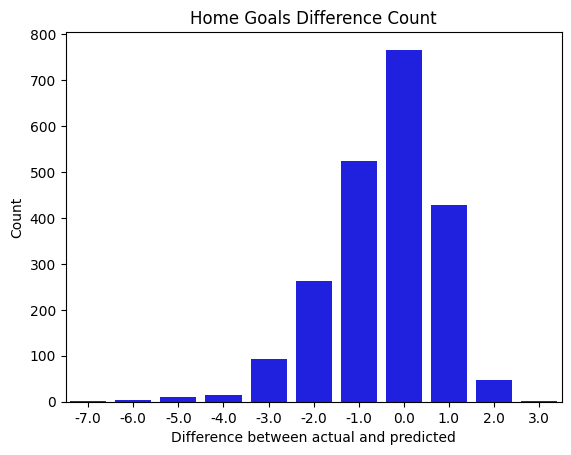

In [49]:
visualisations.histoplot(x_test, ha='Home')

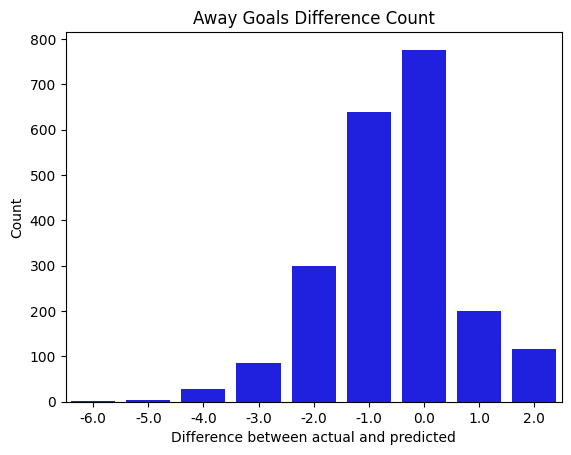

In [50]:
visualisations.histoplot(x_test, ha='Away')

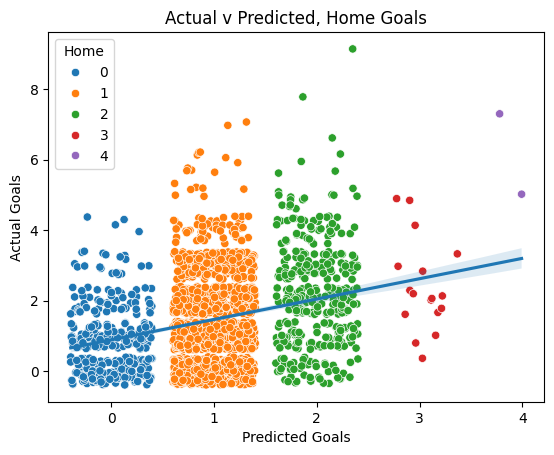

In [51]:
visualisations.actuals_predicted(x_test, ha='Home')

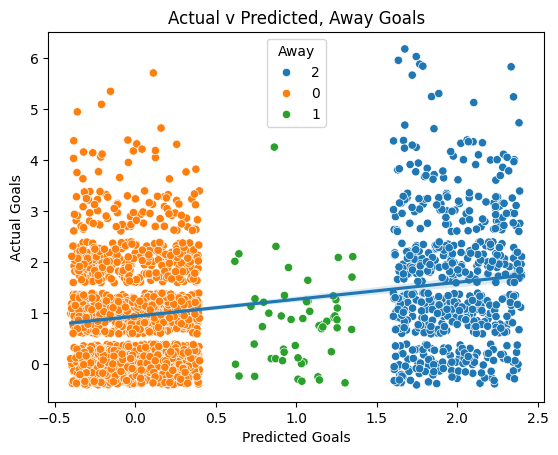

In [52]:
visualisations.actuals_predicted(x_test, ha='Away')

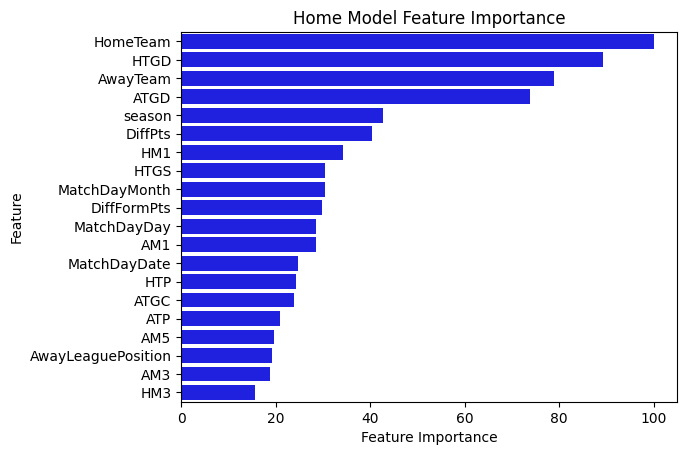

In [53]:
visualisations.plot_features(regressor_1, 'Home',n=20)

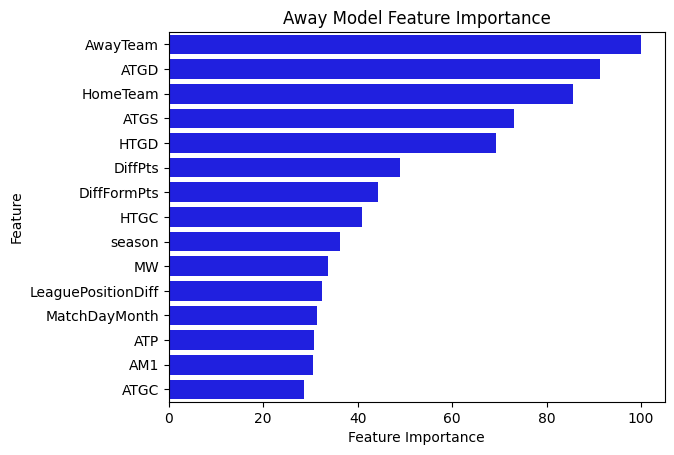

In [54]:
visualisations.plot_features(regressor_2, 'Away')